# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from openai import OpenAI

import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/MNA/Fintech/Week 3/df_news.csv'

In [5]:
df_news = pd.read_csv(file_path)
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.

We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [6]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'],
        'TICKER': row['TICKER'],
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [9]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [10]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [12]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

### Sampling 100 distinct news articles

In [14]:
sampled_df = df_news.sample(n=100, random_state=42).reset_index(drop=True)

In [16]:
sampled_df.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,ANET,"Broadcom, Arista Networks initiated: Wall Stre...","Broadcom, Arista Networks initiated: Wall Stre...",2025-05-28,The Fly,https://finance.yahoo.com/news/broadcom-arista...,"Broadcom, Arista Networks initiated: Wall Stre..."
1,EMR,Investors Heavily Search Emerson Electric Co. ...,Emerson Electric (EMR) has received quite a bi...,2025-05-12,Zacks,https://finance.yahoo.com/news/investors-heavi...,Investors Heavily Search Emerson Electric Co. ...
2,BXP,Why Is Ventas (VTR) Down 2.1% Since Last Earni...,Ventas (VTR) reported earnings 30 days ago. Wh...,2025-05-30,Zacks,https://finance.yahoo.com/news/why-ventas-vtr-...,Why Is Ventas (VTR) Down 2.1% Since Last Earni...
3,QCOM,3 things Nvidia investors should look out for ...,Nvidia's earnings call this week will be a mar...,2025-05-28,Yahoo Finance,https://finance.yahoo.com/news/3-things-nvidia...,3 things Nvidia investors should look out for ...
4,KR,Inflation-weary Americans queue for toilet pap...,Inflation-scarred American consumers are putti...,2025-05-29,Financial Times,https://finance.yahoo.com/news/inflation-weary...,Inflation-weary Americans queue for toilet pap...


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [13]:
from openai import OpenAI
client = OpenAI(api_key = "")

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

As the moonlight danced across the meadow, Luna, the little unicorn, closed her eyes, knowing that with each twinkle of the stars, her dreams would carry her to magical realms filled with shimmering rainbows and friendly talking animals.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset.

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [18]:
prompt_template = """
Given the news headline provided below,
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

### Generate one natural question per article using GPT, where the expected answer is the original article.

In [32]:
questions = []

for summary in sampled_df['SUMMARY']:
    prompt = prompt_template.format(news=summary)
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.4
    )
    question = response.choices[0].message.content.strip()
    questions.append(question)

### Example of a question and answer

#### Question created by GPT

In [33]:
questions[0]

"What are the latest calls made by Wall Street's top analyst regarding Broadcom and Arista Networks?"

#### Asnwer

In [34]:
sampled_df['SUMMARY'][0]

"Broadcom, Arista Networks initiated: Wall Street's top analyst calls"

### Creating a new DataFrame (df_news_questions) with:

* NEWS: the original summary
* QUESTION: the corresponding question generated using GPT

In [35]:
df_news_questions = pd.DataFrame({
    'NEWS': sampled_df['SUMMARY'],
    'QUESTION': questions
})

In [36]:
df_news_questions.head()

,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest calls made by Wall Street'...
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have occurred with Em...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What is the latest update on Ventas (VTR) stoc...
3,Nvidia's earnings call this week will be a mar...,What should I know about Nvidia's upcoming ear...
4,Inflation-scarred American consumers are putti...,What is the current behavior of American consu...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [37]:
def evaluate_no_reranker(df_questions, store):
    ranks = []
    for _, row in df_questions.iterrows():
        question = row['QUESTION']
        target_news = row['NEWS']
        results = store.search(question, k=5)
        retrieved_texts = [r[0] for r in results]
        if target_news in retrieved_texts:
            rank = retrieved_texts.index(target_news)
        else:
            rank = 'not found'
        ranks.append(rank)
    df_questions['NO_RERANKER'] = ranks

In [38]:
evaluate_no_reranker(df_news_questions, faiss_store)

In [39]:
df_news_questions.head()

,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest calls made by Wall Street'...,0
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have occurred with Em...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What is the latest update on Ventas (VTR) stoc...,0
3,Nvidia's earnings call this week will be a mar...,What should I know about Nvidia's upcoming ear...,0
4,Inflation-scarred American consumers are putti...,What is the current behavior of American consu...,3


### Print a count of the NO_RERANKER values

In [41]:
no_reranker_count = df_news_questions['NO_RERANKER'].value_counts(dropna=False)

for val, qty in no_reranker_count.items():
    print(f"value: {val} → {qty} records")

value: 0 → 86 records
value: 1 → 5 records
value: not found → 4 records
value: 2 → 3 records
value: 3 → 1 records
value: 4 → 1 records


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



### Import CrossEncoder

In [ ]:
from sentence_transformers import CrossEncoder

### Test cross encoder

In [43]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = cross_encoder.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

[ 9.218912  -4.0780306]


### Create reranker function

In [44]:
def evaluate_with_reranker(df_questions, store, reranker):
    rerank_ranks = []
    for _, row in df_questions.iterrows():
        question = row['QUESTION']
        target_news = row['NEWS']
        results = store.search(question, k=100)
        candidate_texts = [r[0] for r in results]
        pairs = [(question, doc) for doc in candidate_texts]
        scores = reranker.predict(pairs)
        sorted_indices = np.argsort(scores)[::-1]
        top_5_indices = sorted_indices[:5]
        top_5_texts = [candidate_texts[i] for i in top_5_indices]
        if target_news in top_5_texts:
            rank = top_5_texts.index(target_news)
        else:
            rank = 'not found'
        rerank_ranks.append(rank)
    df_questions['WITH_RERANKER'] = rerank_ranks

In [45]:
evaluate_with_reranker(df_news_questions, faiss_store, cross_encoder)

In [46]:
df_news_questions.head()

,NEWS,QUESTION,NO_RERANKER,WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest calls made by Wall Street'...,0,0
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have occurred with Em...,0,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What is the latest update on Ventas (VTR) stoc...,0,0
3,Nvidia's earnings call this week will be a mar...,What should I know about Nvidia's upcoming ear...,0,0
4,Inflation-scarred American consumers are putti...,What is the current behavior of American consu...,3,0


In [47]:
reranker_count = df_news_questions['WITH_RERANKER'].value_counts(dropna=False)

for val, qty in reranker_count.items():
    print(f"value: {val} → {qty} records")

value: 0 → 91 records
value: 3 → 3 records
value: 2 → 2 records
value: not found → 2 records
value: 4 → 1 records
value: 1 → 1 records


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [48]:
rank_values = [0, 1, 2, 3, 4, 'not found']

comparison_table = pd.DataFrame({
    'NO_RERANKER': [sum(df_news_questions['NO_RERANKER'] == val) for val in rank_values],
    'WITH_RERANKER': [sum(df_news_questions['WITH_RERANKER'] == val) for val in rank_values]
}, index=rank_values)

In [49]:
print("Comparative Table:")
print(comparison_table)

Comparative Table:
           NO_RERANKER  WITH_RERANKER
0                   86             91
1                    5              1
2                    3              2
3                    1              3
4                    1              1
not found            4              2


### Exclude not found

In [50]:
no_reranker_numeric = df_news_questions['NO_RERANKER'].apply(lambda x: x if isinstance(x, int) else None)
with_reranker_numeric = df_news_questions['WITH_RERANKER'].apply(lambda x: x if isinstance(x, int) else None)

### Calculate mean

In [51]:
mean_no_reranker = no_reranker_numeric.mean()
mean_with_reranker = with_reranker_numeric.mean()

In [52]:
print(f"\nMean NO_RERANKER: {mean_no_reranker}")
print(f"Mean WITH_RERANKER: {mean_with_reranker}")


Mean NO_RERANKER: 0.1875
Mean WITH_RERANKER: 0.1836734693877551


### Calculate median

In [54]:
median_no_reranker = no_reranker_numeric.median()
median_with_reranker = with_reranker_numeric.median()

In [56]:
print(f"\nMedian NO_RERANKER: {median_no_reranker}")
print(f"Median WITH_RERANKER: {median_with_reranker}")


Median NO_RERANKER: 0.0
Median WITH_RERANKER: 0.0


### No Reranker vs With Reranker comparisson chart

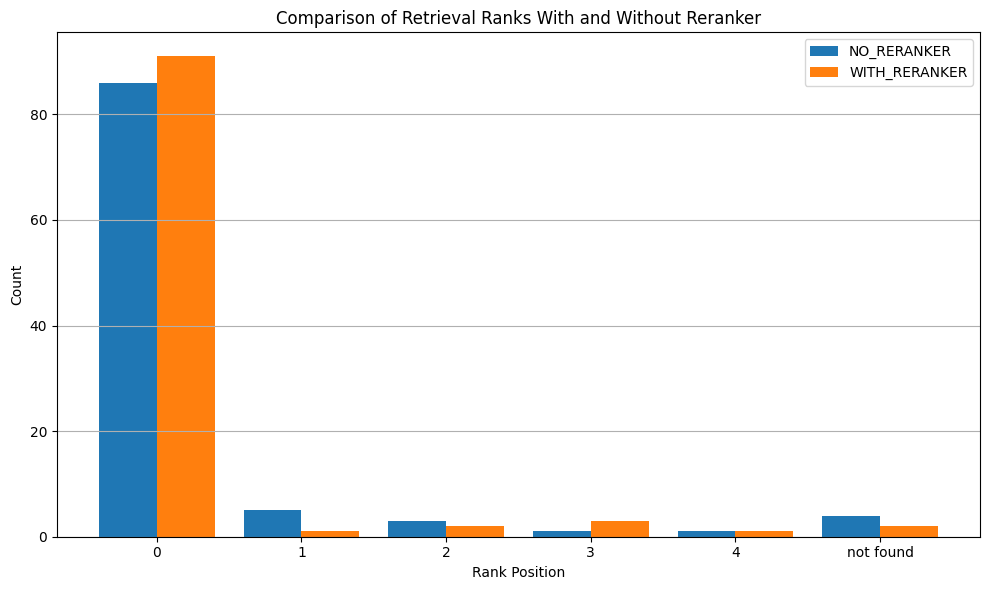

In [53]:
x_labels = [str(val) for val in rank_values]
x = range(len(rank_values))

plt.figure(figsize=(10, 6))
plt.bar(x, comparison_table['NO_RERANKER'], width=0.4, label='NO_RERANKER', align='center')
plt.bar([i + 0.4 for i in x], comparison_table['WITH_RERANKER'], width=0.4, label='WITH_RERANKER', align='center')
plt.xticks([i + 0.2 for i in x], x_labels)
plt.xlabel('Rank Position')
plt.ylabel('Count')
plt.title('Comparison of Retrieval Ranks With and Without Reranker')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **Question 1.** Did reranking improve the **average position** of the correct news?


The average position of correctly retrieved news articles improved slightly, although the potential for enhancement was limited given the strong performance of the baseline model without a reranker. Specifically, the non-reranked version successfully retrieved 86 correct articles at rank 0 out of 100 queries, with only 4 instances marked as "not found." In contrast, the reranked version demonstrated a measurable improvement, retrieving 91 correct articles at rank 0 and reducing the number of "not found" cases to just 2. These results suggest that incorporating a reranker yields a tangible benefit in retrieval accuracy. However, this improvement came at the cost of significantly increased processing time compared to the non-reranked implementation.

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


the non-reranked version successfully retrieved 86 correct articles at posicion 0, the reranked version retrived 91 correct articles at rank 0.

The average retrieval position showed a slight improvement, decreasing from 0.1875 without reranking to 0.1836 with reranking. Given that a position of 0 represents a perfect retrieval outcome, this reduction of 0.0039 indicates a modest yet meaningful enhancement in performance. While the magnitude of the improvement is not substantial, it nonetheless reflects the positive impact of incorporating a reranking mechanism.